# The MNIST data set

This data set has been a main-stay for development of ideas in deep learning. It consists to 60,000 labelled hand-written digits, as 28 x 28 pixel fields, and can be downloaded from: 
http://deeplearning.net/data/mnist/mnist.pkl.gz

The data comes in Python's <a href="https://docs.python.org/2/library/pickle.html">pickle</a> format, and we'll begin by opening it and taking a first look at the contents:

In [2]:
import gzip, cPickle

file = '~/data/mnist.pkl.gz'
f = gzip.open(file, 'rb')
train, vdt, test = cPickle.load(f)
f.close()

# data set:
train_x, train_y = train
valid_x, valid_y = vdt
test_x, test_y = test

print(train_x.shape)
print(train_y.shape)
print(train)

(50000, 784)
(50000,)
(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8]))


Next, select and view a random sample of the images. This uses a helper function <tt>tile_raster_images()</tt> from the file <tt>utils.py</tt> (borrowed from the <a href="http://deeplearning.net/software/theano/">Theano</a> repository).

[5 2 3 8 7 2 9 8 1]


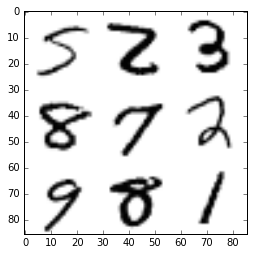

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
from utils import tile_raster_images 

idx = np.random.randint(50000, size=9)
idx.sort()
image = tile_raster_images(
                         X=train_x[idx],
                         img_shape=(28, 28), 
                         tile_shape=(3,3),
                         tile_spacing=(1, 1))
plt.imshow(image, cmap='Greys')
print(train_y[idx])

Here's the distribution of digit classes in the training set (and you can replace 'train' by 'valid' or 'test'):

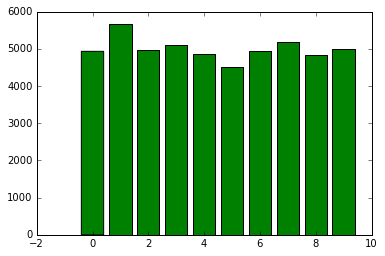

In [4]:
plt.hist(train_y, range=(-0.5,9.5), rwidth=0.8, facecolor='green')
plt.show()

# Logistic regression

MNIST is primarily a challenge data set for classification. So before trying anything more fancy, one should run logistic regression as a baseline. 

Start by setting up Keras and re-shaping the response variable to 1-hot vectors of length 10:

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# reshape training data:
size = train_y.shape[0]
y = np.zeros([size, 10])
for i in range(size): y[i, train_y[i]] = 1

Using TensorFlow backend.


Now build and compile the model - 784 input (pixel) units connected to a 10-way softmax layer: 

In [6]:
model_lr = Sequential()
model_lr.add(Dense(10, input_dim=784))
model_lr.add(Activation("softmax"))
model_lr.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01, momentum=0.01, decay=0.01, nesterov=True))
model_lr.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 784)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 10)                    7850                
Activation (activation)       (None, 10)                    0                   
--------------------------------------------------------------------------------
Total params: 7850
--------------------------------------------------------------------------------


And fit the model:

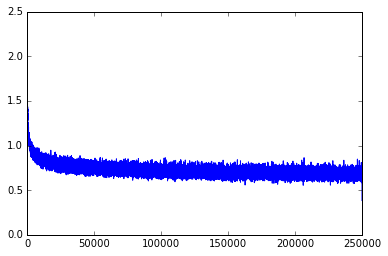

In [10]:
history = LossHistory()
model_lr.fit(train_x, y, 
          batch_size=20,
          nb_epoch=100,
          verbose=0, 
          callbacks=[history])

# show the SGD progress:
def movingaverage(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

plt.plot(movingaverage(history.losses, 20))
plt.show()

To view the performance (on the validation set) it's convenient to use <a href="http://pandas.pydata.org">pandas</a>.

In [11]:
import pandas as pd

tp = model_lr.predict(valid_x)
pred = np.array( [np.argmax( tp[i] ) for i in range(len(tp))] )
ct = pd.crosstab(valid_y, pred, rownames=["Actual"], colnames=["Predicted"], margins=False); ct

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,927,0,7,2,2,6,15,3,23,6
1,0,1020,4,10,1,4,4,2,19,0
2,8,19,831,16,19,1,26,23,38,9
3,8,9,31,871,1,27,9,5,50,19
4,2,17,4,1,855,0,9,1,13,81
5,31,13,17,102,26,625,32,10,36,23
6,7,12,15,1,6,8,907,1,10,0
7,19,41,16,4,11,0,0,948,5,46
8,6,46,13,47,8,21,6,11,827,24


The 'overall accuracy' can be measured as the proportion on the diagonal:

In [12]:
print(sum( np.diagonal(ct) )/10000.0)

0.8622


It's interesting to give an interpetation of the network weights from the input (pixel) units to the 10 softmax units. We can view these arrays as 10 images, and then we see that the model has learnt a ghostly version of the 10 digits - in each case a sort of coarse average over the training data: 

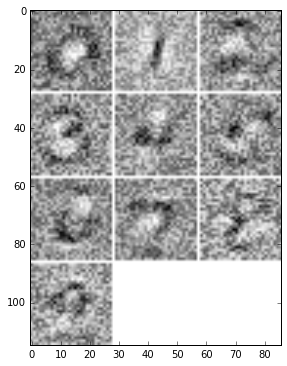

In [13]:
image_array = tile_raster_images(
                         X=model_lr.get_weights()[0].transpose(),
                         img_shape=(28,28), 
                         tile_shape=(4,3),
                         tile_spacing=(1,1))
plt.figure(figsize=(6,6))
plt.imshow(image_array, cmap='Greys', aspect='equal')

I find (especially if I view it at a sideways angle to the computer screen) that most of the digits are recognisable here, especially 0,1,2,3 and 7.

# Multi-layer perceptron

Now let's use a bit more of the power of neural networks, and build a simple multilayer model. We'll add two hidden layers - one fewer than the version written in Torch at <a href="https://github.com/box121209/MNIST-t-SNE/blob/master/mnist.lua">MNIST-t-SNE/mnist.lua</a>:

In [14]:
# declare model:
from keras.layers.core import Dense, Activation, Dropout

model_mlp = Sequential()
model_mlp.add(Dense(128, input_dim=784))
model_mlp.add(Activation("relu"))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(9))
model_mlp.add(Activation("relu"))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(10))
model_mlp.add(Activation("softmax"))

model_mlp.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01, momentum=0.01, decay=0.0, nesterov=True))

# how many parameters?
model_mlp.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 784)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 128)                   100480              
Activation (activation)       (None, 128)                   0                   
Dropout (dropout)             (None, 128)                   0                   
Dense (dense)                 (None, 9)                     1161                
Activation (activation)       (None, 9)                     0                   
Dropout (dropout)             (None, 9)                     0                   
Dense (dense)                 (None, 10)                    100                 
Activation (activation)       (None, 10)                    0               

(Why 9 units in the last hidden layer? Because there are 10 classes, and I'd like to concentrate these at the vertices of a maximal-dimensional simplex.)

Two points to note: we're using <a href="http://cs231n.github.io/neural-networks-1/">rectified linear units (relu)</a>, and we're using <a href="https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf">dropout</a> - both of which are popular ways to speed up the training and reduce over-fitting. 

In [15]:
# fit model to training data:
history = LossHistory()
model_mlp.fit(train_x, y, 
          batch_size=20, 
          nb_epoch=100,
          verbose=0, 
          callbacks=[history])

We find that this model greatly out-performs logistic regression - and, for such a simple network, gets surprisingly close to optimal classification performance: 

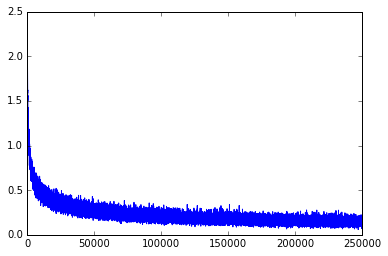

0.9755


Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,972,0,7,0,0,2,4,2,1,3
1,0,1049,1,2,1,1,3,2,5,0
2,1,1,970,2,0,1,2,6,7,0
3,1,0,5,1005,0,8,0,3,7,1
4,0,5,0,0,955,0,7,1,1,14
5,4,0,4,13,3,871,10,3,6,1
6,2,1,0,0,2,3,957,0,2,0
7,0,3,4,1,0,0,0,1066,2,14
8,1,3,5,4,1,3,4,2,981,5


In [16]:
# show the SGD progress:
plt.plot(movingaverage(history.losses, 20))
plt.show()

tp = model_mlp.predict(valid_x)
pred = np.array( [np.argmax( tp[i] ) for i in range(len(tp))] )
ct = pd.crosstab(valid_y, pred, rownames=["Actual"], colnames=["Predicted"], margins=False); 

# the overall accuracy:
print(sum( np.diagonal(ct) )/10000.0)
# and the confusion matrix:
ct

Just as we did for logistic regression, let's give a visual inpretation of the lowest layer of weights. These form 128 28x28-pixel images, and each image can be viewed as a feature (or image filter) which is used by the classifier:

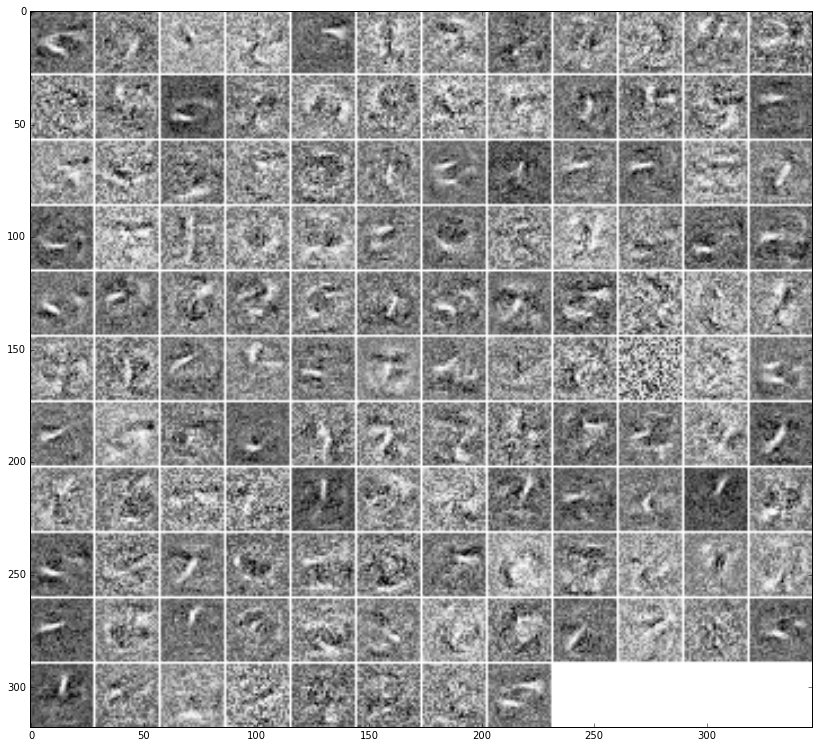

In [19]:
image_array = tile_raster_images(
                         X=model_mlp.get_weights()[0].transpose(),
                         img_shape=(28,28), 
                         tile_shape=(11,12),
                         tile_spacing=(1,1))
plt.figure(figsize=(14,14))
plt.imshow(image_array, cmap='Greys', aspect='equal', interpolation='bilinear')

For later use, and since training the model is time-consuming, let's save the model weights to disk:

In [20]:
np.save("data/mnist/MNIST_model_784_128_9_10sm.npy", model_mlp.get_weights())

# Visualising the data points

First, let's view the data points in 784-dimensional pixel space under a dimensional reduction to 2 dimensions. The dimensional reduction method we'll use is t-SNE. (For an explanation see L. van der Maaten, G. Hinton, <a href="http://www.cs.toronto.edu/~hinton/absps/tsne.pdf">Visualizing Data using t-SNE</a>, 2008; or L. van der Maaten, <a href="http://arxiv.org/pdf/1301.3342v2.pdf">Barnes-Hut-SNE</a>, 2013, for the faster algorithm we're using here). 

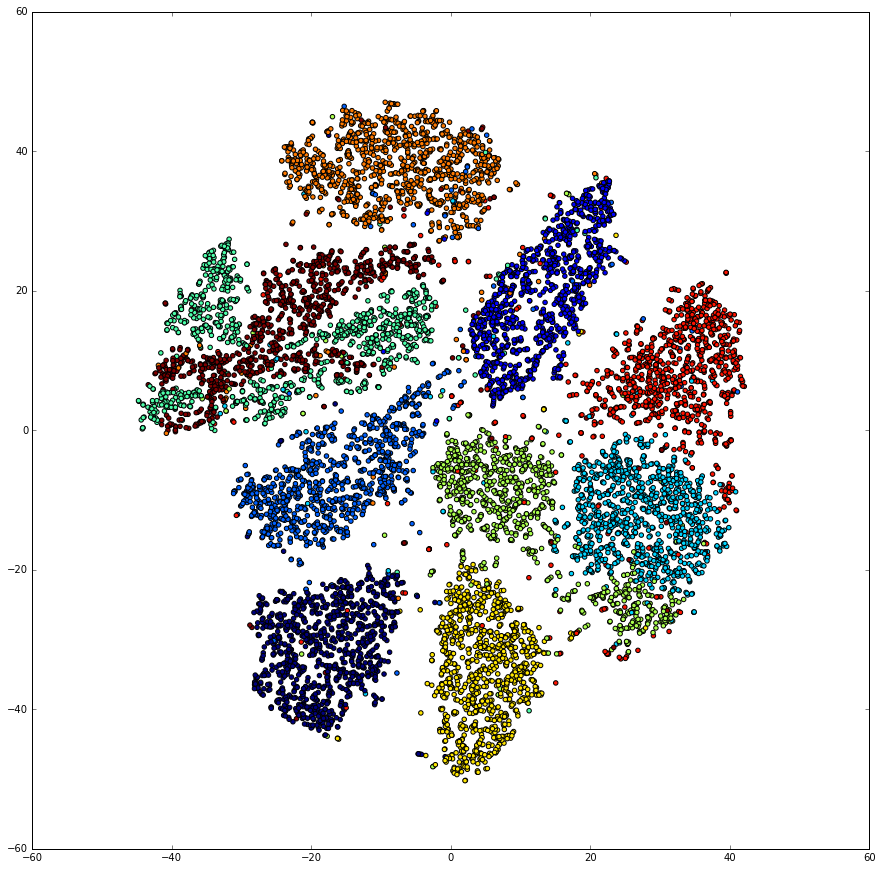

In [8]:
from tsne import bh_sne

mnist_pixels = valid_x.astype(float)
pixels_2d = bh_sne(mnist_pixels)
digit = valid_y

plt.figure(figsize=(15,15))
plt.scatter(pixels_2d[:,0], pixels_2d[:,1], c=digit)
plt.show()

What we see is a good representation of how the digit classes, represented by the colours, are separated in pixel space. In effect, it gives an intuitive explanation for the 86% success rate achieved by logistic regression above.

Next, let's compare this with the same plot but projecting from the 9-dimensional image of the MLP instead of from pixel space. (This was discussed in the blog post <a href="http://billsdata.net/?p=91">An enhanced t-SNE plot for MNIST digits</a>. I'm repeating it here just as an exercise in Keras.)

First, we load the MLP model fitted earlier:

In [341]:
wt = np.load("data/mnist/MNIST_model_784_128_9_10sm.npy")
[w.shape for w in wt]

[(784, 128), (128,), (128, 9), (9,), (9, 10), (10,)]

We now want to build a network from the lower layers, just removing the softmax layer. Then, for each input 28x28 image the output will be a 9-dimensional vector representation. To do this, we simply declare and compile a network of the right shape, and then set the weights as required: 

In [260]:
proj = Sequential()
proj.add(Dense(128, input_dim=784))
proj.add(Activation("relu"))
proj.add(Dense(9))
proj.add(Activation("relu"))

# note that a compile step is needed before the network can be used!
proj.compile(loss='mse', optimizer='sgd') 
proj.set_weights(wt[range(4)])

Why are we doing this? Because the MLP model on 28x28 images is completely equivalent to a logistic regression model on the top layer, i.e. on the 9-dimensional representation. So a 97% success rate of the MLP model means that in the 9-dimensional representation, logistic regression achieves 97% success. This implies that the digit classes are nicely separated in the 9-dimensional representation, and this should be visible in the t-SNE reduction: 

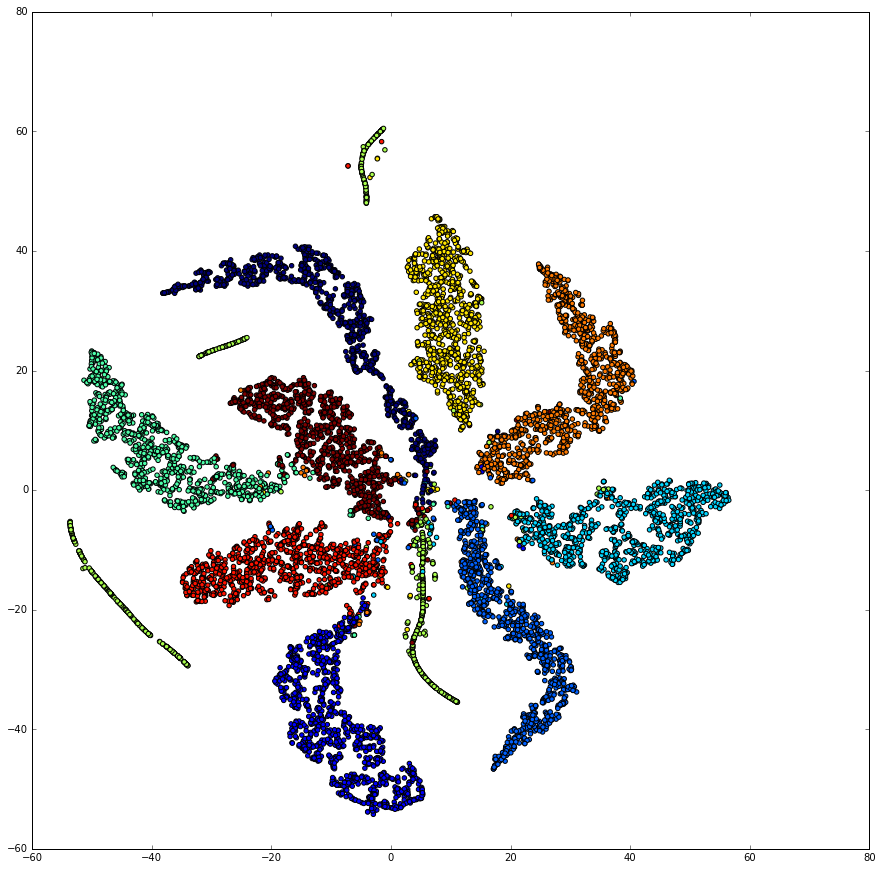

In [326]:
valid_x_9dim = proj.predict(valid_x)
valid_x_9dim.shape
proj_2d = bh_sne(valid_x_9dim)

plt.figure(figsize=(15,15))
plt.scatter(proj_2d[:,0], proj_2d[:,1], c=digit)
plt.show()

(Incidentally, how did we achieve that sharper separation than in pixel space? By injecting class information via the training process!)

<b>Question:</b> in the visualisations above using <a href="http://matplotlib.org">matplotlib</a>, how do we represent the individual points by text characters (as in the <a href="http://billsdata.net/?p=91">blog</a> referred to above, which used R's <tt>text()</tt> function)? I gave up trying to figure it out :(